# Vehicle Detection and Tracking
## 0. Import Packages

In [5]:
import time
import pickle

import seaborn as sns

%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob

from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from scipy.ndimage.measurements import label

from sklearn.model_selection import train_test_split

from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Code from project module quizzes 

In [6]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    
    features = []
    
    for file in imgs:
        
        file_features = []
        image = mpimg.imread(file)
        
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    
    return features

def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap
    
def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def draw_labeled_bboxes(img, labels):
    for car_number in range(1, labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    return img


## Histogram of Oriented Gradients (HOG) Feature Extraction on a Labeled Training Set of              Images and Training Linear SVM Classifier



In [7]:
# Read in cars and notcars
vehicles = glob.glob('images/vehicles/*/*.png')
non_vehicles = glob.glob('images/non-vehicles/*/*.png')

print(len(vehicles), " vehicle images loaded")
print(len(non_vehicles), " non-vehicle images loaded")

8792  vehicle images loaded
8968  non-vehicle images loaded


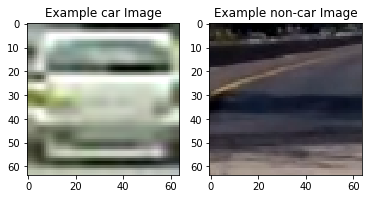

In [8]:
# Plot example images   
car_ind = np.random.randint(0, len(vehicles))
notcar_ind = np.random.randint(0, len(non_vehicles))
    
# Read in car / not-car images
car_image = mpimg.imread(vehicles[car_ind])
notcar_image = mpimg.imread(non_vehicles[notcar_ind])


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example non-car Image')

In [11]:
def trainingHOG(cars, notcars):
    
    print("Wait... It will take a few minutes")
    
    color_space = 'YCrCb'
    orient = 9  #HOG orientations
    pix_per_cell = 8 #HOG pixels per cell
    cell_per_block = 2 #HOG cells per block
    hog_channel = 'ALL'

    ystart = 400
    ystop = 656
    scale = 1.5

    spatial_size = (16, 16) #Spatial binning dimensions
    hist_bins = 16    #Number of histogram bins

    spatial_feat = True #Spatial features on or off
    hist_feat = True #Histogram features on or off
    hog_feat = True #HOG features on or off

    car_features = extract_features(cars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features = extract_features(notcars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)

    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        

    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)

    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    print('Using ',orient,' orientations, ',pix_per_cell,
        ' pixels per cell and ', cell_per_block,' cells per block')
    print('Feature vector length is ', len(X_train[0]))

    # Use a linear SVC 
    svc = LinearSVC()
    print("Using SVC")

    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), ' seconds to train SVC')

    # Check the score of the SVC
    print('Test Accuracy of SVC is ', round(svc.score(X_test, y_test), 4))

    # Check the prediction time for a single sample
    t=time.time()

    print("Done")
    
    return svc



In [12]:
cars = []
notcars = []

for image in vehicles:
    cars.append(image)

for image in non_vehicles:
    notcars.append(image)
    
# traing HOG features
svcHOG = trainingHOG(cars, notcars)

Wait... It will take a few minutes
Using  9  orientations,  8  pixels per cell and  2  cells per block
Feature vector length is  6108
Using SVC
18.55  seconds to train SVC
Test Accuracy of SVC is  0.9913
Done


 No. of features for pix_per_cell-  8 cell_per_block - 1 is 576
 No. of features for pix_per_cell-  16 cell_per_block - 1 is 144
 No. of features for pix_per_cell-  8 cell_per_block - 2 is 1764
 No. of features for pix_per_cell-  16 cell_per_block - 2 is 324


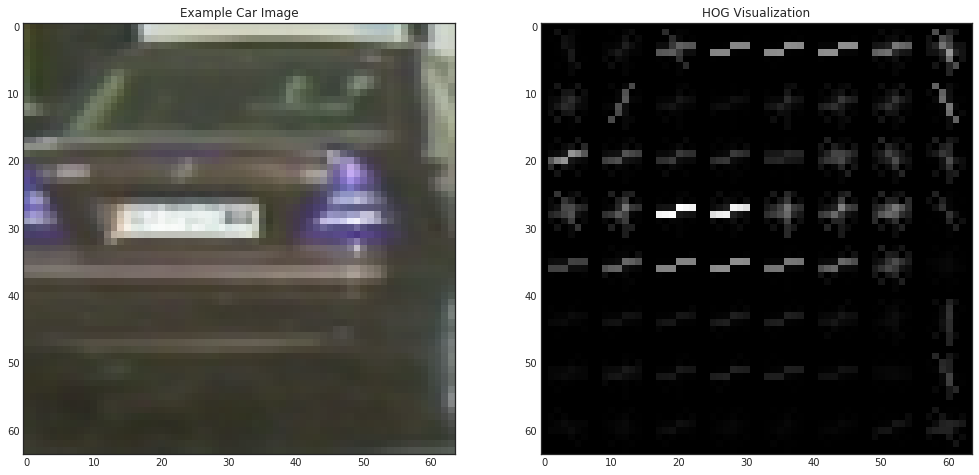

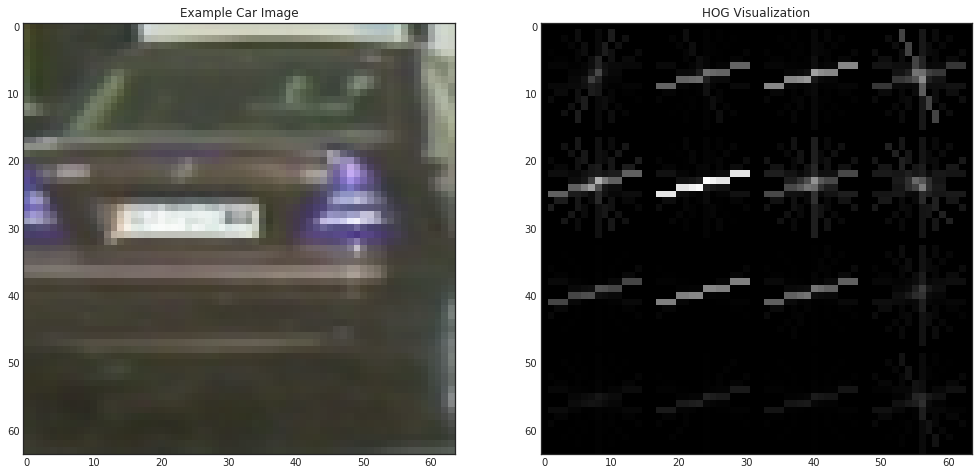

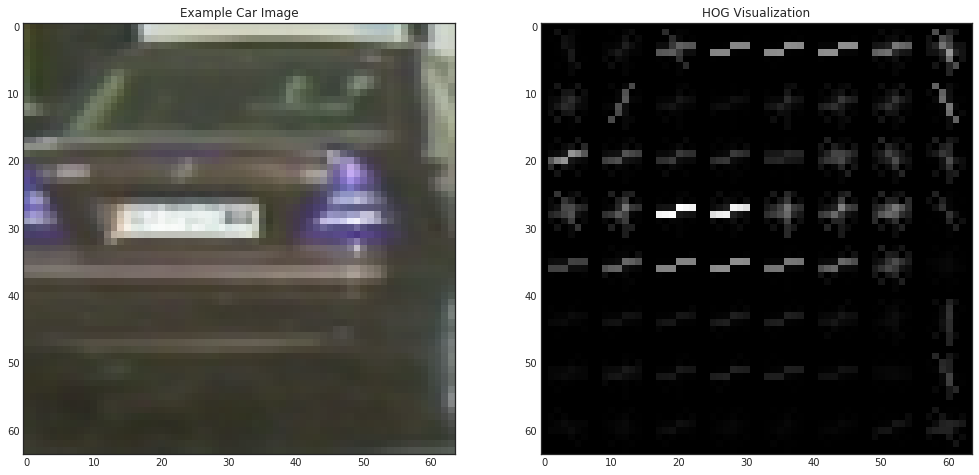

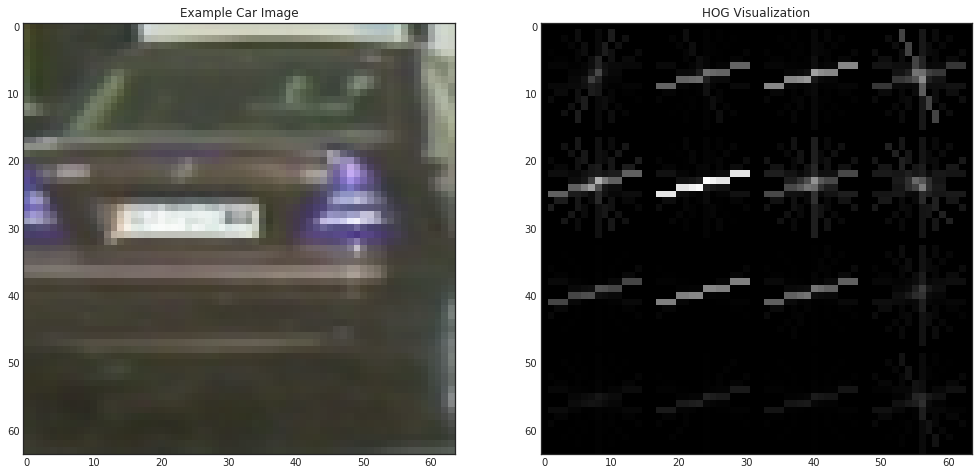

In [13]:
# Extract HOG features
pix_per_cell = [8, 16, 8, 16]
cell_per_block = [1, 1, 2, 2]
orient = [9, 9, 9, 9]

for i in range(len(pix_per_cell)):
# Input is an image of single channel or gray
    car_ind = 1000
    car_image = cv2.imread(cars[car_ind])

    gray = cv2.cvtColor(car_image, cv2.COLOR_BGR2GRAY)
    features, hog_image = get_hog_features(gray, orient[i], pix_per_cell[i], cell_per_block[i],
                             vis=True, feature_vec=False)
    feature_flatten = features.ravel()
    # If feature_vector=True then hog will automatically ravel

    # Plot the examples
    with sns.axes_style("white"):
        fig = plt.figure(figsize=(17, 17))
        plt.subplot(121)
        plt.imshow(car_image, cmap='gray')
        plt.title('Example Car Image')
        plt.subplot(122)
        plt.imshow(hog_image, cmap='gray')
        plt.title('HOG Visualization')
        print(" No. of features for pix_per_cell- ", pix_per_cell[i], "cell_per_block -", cell_per_block[i], "is", 
              len(feature_flatten))

 No. of features for pix_per_cell  8 cell_per_block  1  is  576
 No. of features for pix_per_cell  16 cell_per_block  1  is  144
 No. of features for pix_per_cell  8 cell_per_block  2  is  1764
 No. of features for pix_per_cell  16 cell_per_block  2  is  324


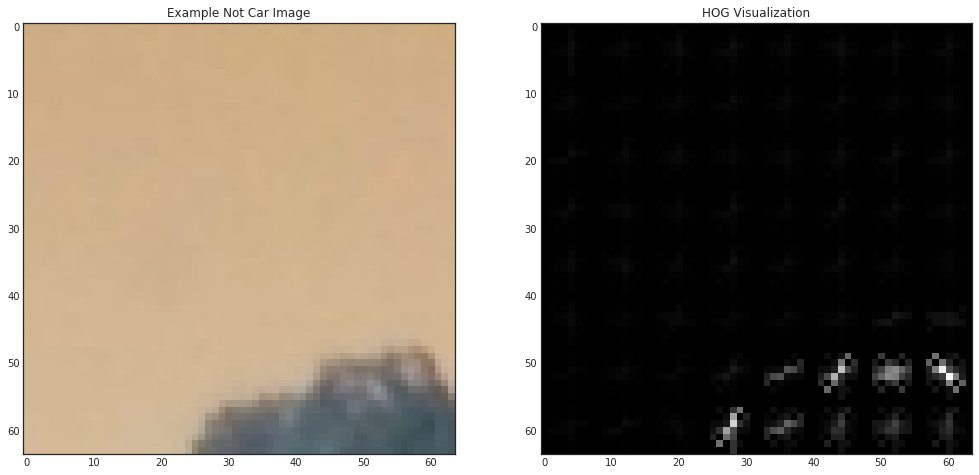

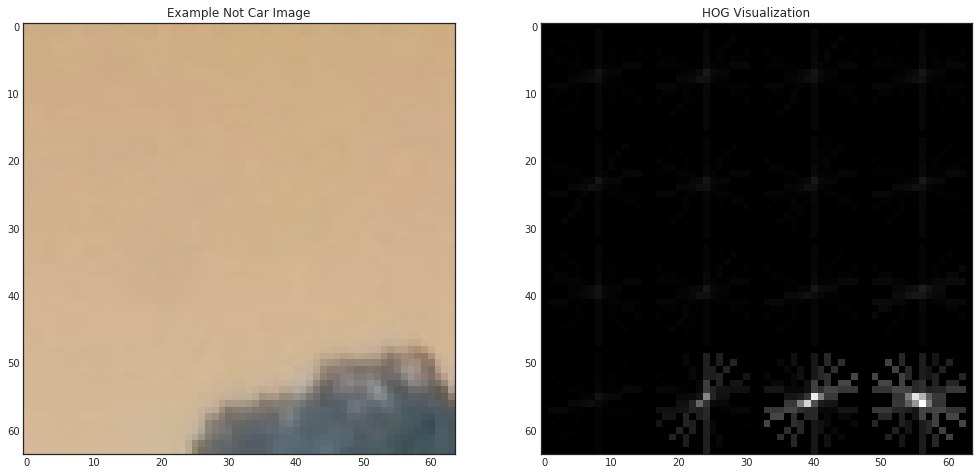

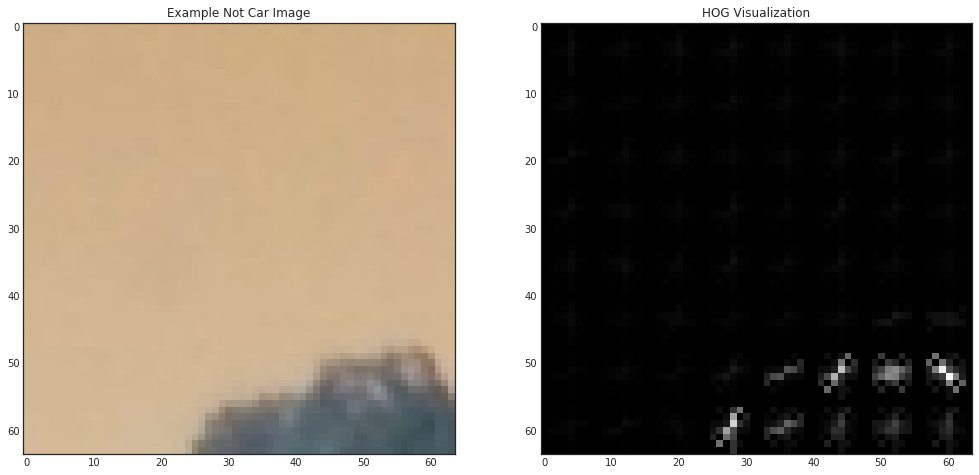

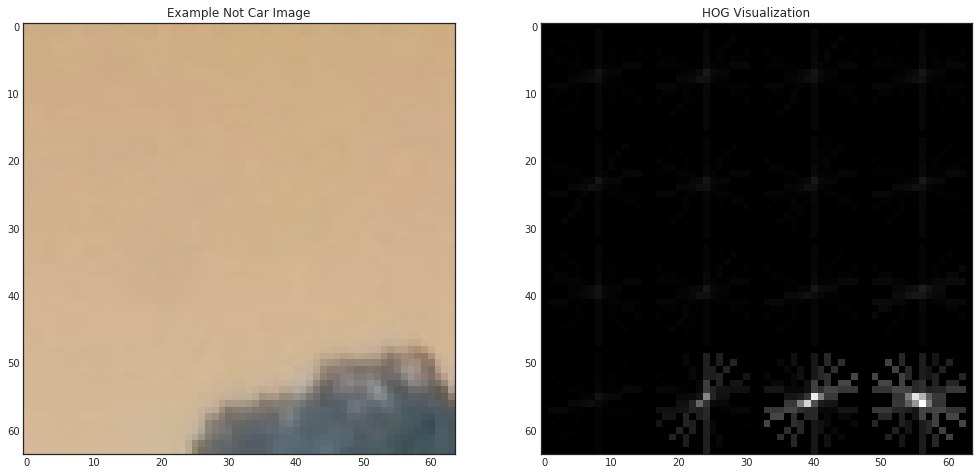

In [14]:
# Extract hog features
pix_per_cell = [8, 16, 8, 16]
cell_per_block = [1, 1, 2, 2]
orient = [9, 9, 9, 9]

for i in range(len(pix_per_cell)):
# Input is an image of single channel or gray
    not_car_ind = 1000
    not_car_image = cv2.imread(notcars[not_car_ind])

    gray = cv2.cvtColor(not_car_image, cv2.COLOR_BGR2GRAY)
    features, hog_image = get_hog_features(gray, orient[i], pix_per_cell[i], cell_per_block[i],
                             vis=True, feature_vec=False)
    feature_flatten = features.ravel()
    # If feature_vector=True then hog will automatically ravel

    # Plot the examples
    with sns.axes_style("white"):
        fig = plt.figure(figsize=(17, 17))
        plt.subplot(121)
        plt.imshow(not_car_image, cmap='gray')
        plt.title('Example Not Car Image')
        plt.subplot(122)
        plt.imshow(hog_image, cmap='gray')
        plt.title('HOG Visualization')
        print(" No. of features for pix_per_cell ", pix_per_cell[i], "cell_per_block ", cell_per_block[i], " is ", 
              len(feature_flatten))

## Sliding-Window Technique and using Trained Classifier to search for cars in images.



In [15]:
# This function predicts car position
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    boxes = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            # Reshape the features
            test_prediction = svc.predict(hog_features.reshape(1, -1))

            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))

    return boxes

In [16]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

## Test pipeline on videos and follow detected cars



In [17]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows


In [18]:
# This function returns image with detection

def process_image(image):
    global last_bboxes
    
    bboxes = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    last_bboxes.append(bboxes)
    last_bboxes = last_bboxes[-10:]
    
    # Read in image similar to one shown above 
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat, [bbox for bboxes in last_bboxes for bbox in bboxes])

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 5)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    return draw_img


In [19]:
import collections 

# heatmaps = collections.deque(maxlen=7)
# global heatmaps

def draw_boxes_video(image):
    draw_image = np.copy(image)
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    xy_window = [[80, 80], [96, 96], [128, 128]]
    x_start_stop = [[700, None], [700, None], [700, None]]
    y_start_stop = [[390, 540], [390, 600], [390, 640]]

    windows = slide_window(image, x_start_stop=x_start_stop[0], y_start_stop=y_start_stop[0], 
                    xy_window=xy_window[0], xy_overlap=(0.8, 0.8))

    windows += slide_window(image, x_start_stop=x_start_stop[1], y_start_stop=y_start_stop[1], 
                    xy_window=xy_window[1], xy_overlap=(0.75, 0.75))

    windows += slide_window(image, x_start_stop=x_start_stop[2], y_start_stop=y_start_stop[2], 
                    xy_window=xy_window[2], xy_overlap=(0.75, 0.75))

    hot_windows = []
    hot_windows += (search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat))

    # Add heat to each box in box list
    heat = add_heat(heat, hot_windows)
    
    ## Utilize deque
    #heatmaps.append(heat)
    #heatmap_sum = sum(heatmaps)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 5)

    # Find final boxes from heatmap using label function
    labels = label(heat)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    return draw_img

In [20]:
def process_car(image):
    global svcHOG
    
    boxes = find_cars(image, ystart, ystop, scale, svcHOG, None, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    window_img = draw_boxes(image, boxes, color=(0, 0, 255), thick=6)  

    out_img = aggregate_boxes(image, boxes, draw=draw)

    if draw:
        fig = plt.figure(figsize=(10,5))
        plt.subplot(121)
        plt.imshow(window_img)
        plt.title('with Bounding boxes')
        plt.subplot(122)
        plt.imshow(out_img)
        plt.title('After HeatMap filtering')
        fig.tight_layout()
    return out_img

In [23]:
video = VideoFileClip("project_video.mp4")
project_clip = video.fl_image(draw_boxes_video)
video_output = "project_video_output.mp4"
%time project_clip.write_videofile(video_output, audio=False)

TypeError: unsupported operand type(s) for //: 'int' and 'list'

In [ ]:
HTML("""
<video width="980" height="550" controls>
  <source src="{0}">
</video>
""".format(project_output_file))

In [ ]:
last_bboxes = []

project_output_file = "project_output.mp4"

project_video = VideoFileClip("project_video.mp4")
project_video.reader.close()
project_video.audio.reader.close_proc()

project_output = project_video.fl_image(process_image)
%time project_output.write_videofile(project_output_file, audio=False)

In [ ]:
HTML("""
<video width="980" height="550" controls>
  <source src="{0}">
</video>
""".format(project_output_file))

## Estimate a Bounding Box for Cars detected



In [ ]:
files = ['test_images/test1.jpg','test_images/test2.jpg','test_images/test3.jpg','test_images/test4.jpg',
         'test_images/test5.jpg','test_images/test6.jpg']

for file in files:

    ystart = 400
    ystop = 656
    scale = 1.5

    image = mpimg.imread(file)
    box_list = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, 
                         spatial_size, hist_bins)

# Read in image similar to one shown above 
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

# Add heat to each box in box list
    heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    fig = plt.figure(figsize=(17, 17))
    plt.subplot(121)
    plt.imshow(draw_img)
    plt.title('Car Positions',fontsize=20)
    plt.subplot(122)

    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map',fontsize=20)
    fig.tight_layout()